# 2. 거울아 거울아, 나는 멍멍이 상이니, 아니면 냥이 상이니? [프로젝트]

## 2-1. 프로젝트: 새로운 데이터셋으로 나만의 이미지 분류기 만들어보기

In [1]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [2]:
import tensorflow_datasets as tfds
print(tfds.__version__)

4.4.0


In [3]:
import os
data_path = os.path.join(os.getcwd(), 'data', 'tf_flowers')

if not os.path.exists(data_path):
    os.makedirs(data_path)

In [4]:
import os

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name='tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    data_dir= data_path,
    download=False,
    with_info=True,
    as_supervised=True,
)

### 1. 데이터 확인 및 전처리

In [5]:
# 데이터 확인

print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


In [6]:
# 그래프 세팅

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

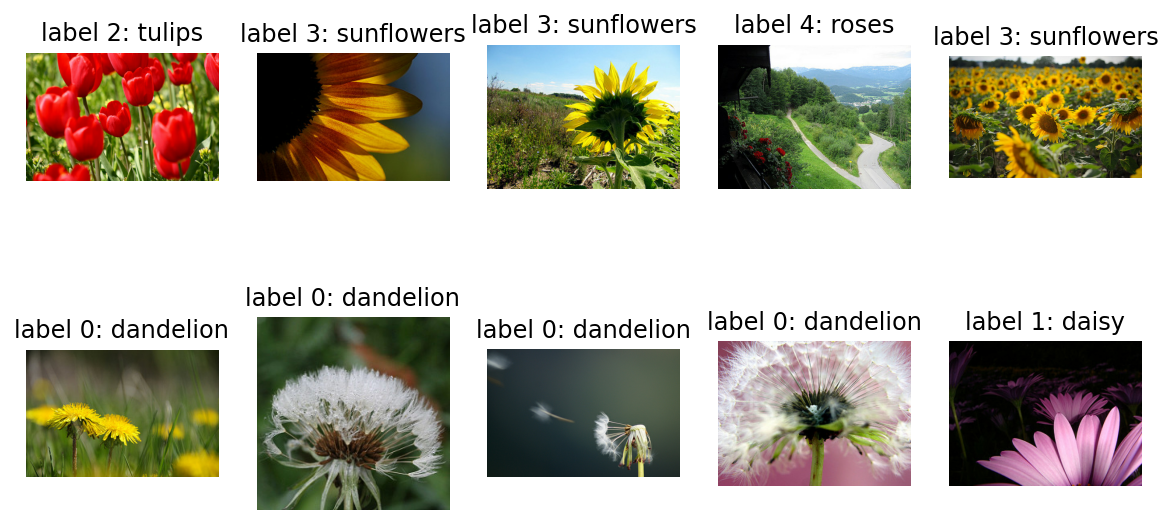

In [7]:
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):  # 10개의 데이터를 가져 옵니다.
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [8]:
# 클래스 개수 확인

get_label_name

<bound method ClassLabel.int2str of ClassLabel(shape=(), dtype=tf.int64, num_classes=5)>

In [9]:
IMG_SIZE = 224 # 리사이징할 이미지의 크기

def format_example(image, label, num_classes=5):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/255) # 픽셀값의 scale 수정
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    label = tf.one_hot(label, num_classes)
    return image, label

In [10]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

print(train)
print(validation)
print(test)

<MapDataset shapes: ((224, 224, 3), (5,)), types: (tf.float32, tf.float32)>
<MapDataset shapes: ((224, 224, 3), (5,)), types: (tf.float32, tf.float32)>
<MapDataset shapes: ((224, 224, 3), (5,)), types: (tf.float32, tf.float32)>


In [11]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_batches = validation.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_batches = test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for image_batch, label_batch in train_batches.take(1):
    break

image_batch.shape, label_batch.shape

(TensorShape([32, 224, 224, 3]), TensorShape([32, 5]))

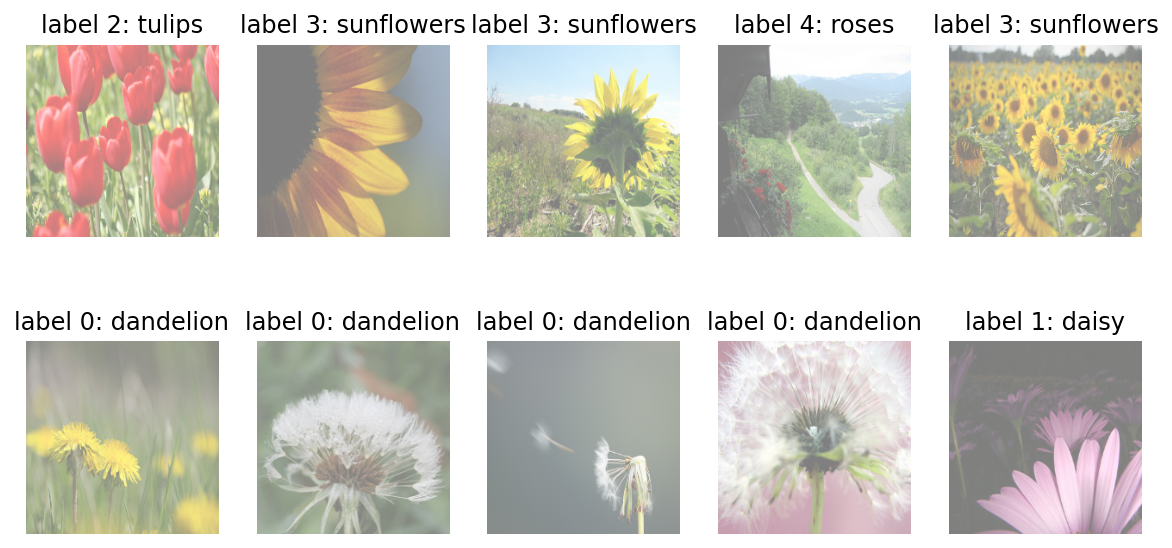

In [12]:
import numpy as np

plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {np.argmax(label)}: {get_label_name(np.argmax(label))}')
    plt.axis('off')

### 2. 신경망 구성하기
- Transfer learning
- 모델 선택하기

In [13]:
dir(tf.keras.applications)

['DenseNet121',
 'DenseNet169',
 'DenseNet201',
 'EfficientNetB0',
 'EfficientNetB1',
 'EfficientNetB2',
 'EfficientNetB3',
 'EfficientNetB4',
 'EfficientNetB5',
 'EfficientNetB6',
 'EfficientNetB7',
 'InceptionResNetV2',
 'InceptionV3',
 'MobileNet',
 'MobileNetV2',
 'MobileNetV3Large',
 'MobileNetV3Small',
 'NASNetLarge',
 'NASNetMobile',
 'ResNet101',
 'ResNet101V2',
 'ResNet152',
 'ResNet152V2',
 'ResNet50',
 'ResNet50V2',
 'VGG16',
 'VGG19',
 'Xception',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_sys',
 'densenet',
 'efficientnet',
 'imagenet_utils',
 'inception_resnet_v2',
 'inception_v3',
 'mobilenet',
 'mobilenet_v2',
 'mobilenet_v3',
 'nasnet',
 'resnet',
 'resnet50',
 'resnet_v2',
 'vgg16',
 'vgg19',
 'xception']

In [14]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# VGG19으로 선정 / fully-connected layer는 제외
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                             include_top=False,
                                             weights='imagenet')

17235968/17225924 [==============================] - 0s 0us/step


In [15]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [16]:
with tf.device('/GPU:0'):
    from tensorflow.keras.models import Sequential

    model = tf.keras.Sequential([
      base_model,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(5, activation='softmax')
    ])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 3,760,325
Trainable params: 3,736,389
Non-trainable params: 23,936
_________________________________________

In [18]:
with tf.device('/GPU:0'):
    learning = 0.001
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning),
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(name='precision'),
                            tf.keras.metrics.Recall(name='recall')]
    )

### 3. 에폭 사전 준비

In [19]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

### 4. 학습시키기

In [20]:
with tf.device('/GPU:0'):
    history = model.fit(train_batches,
                        epochs=100,
                        validation_data=validation_batches,
                        callbacks=[early_stopping])

Epoch 1/100
92/92 [==============================] - 28s 220ms/step - loss: 0.7876 - accuracy: 0.7827 - precision: 0.8085 - recall: 0.7694 - val_loss: 4.6270 - val_accuracy: 0.6866 - val_precision: 0.6923 - val_recall: 0.6866
Epoch 2/100
92/92 [==============================] - 19s 201ms/step - loss: 0.3546 - accuracy: 0.8832 - precision: 0.9030 - recall: 0.8692 - val_loss: 3.9775 - val_accuracy: 0.6540 - val_precision: 0.6575 - val_recall: 0.6540
Epoch 3/100
92/92 [==============================] - 19s 196ms/step - loss: 0.2804 - accuracy: 0.9142 - precision: 0.9287 - recall: 0.9002 - val_loss: 1.2538 - val_accuracy: 0.7820 - val_precision: 0.7955 - val_recall: 0.7738
Epoch 4/100
92/92 [==============================] - 19s 195ms/step - loss: 0.2934 - accuracy: 0.9179 - precision: 0.9282 - recall: 0.9114 - val_loss: 1.0872 - val_accuracy: 0.7847 - val_precision: 0.7867 - val_recall: 0.7738
Epoch 5/100
92/92 [==============================] - 18s 192ms/step - loss: 0.1940 - accuracy: 0

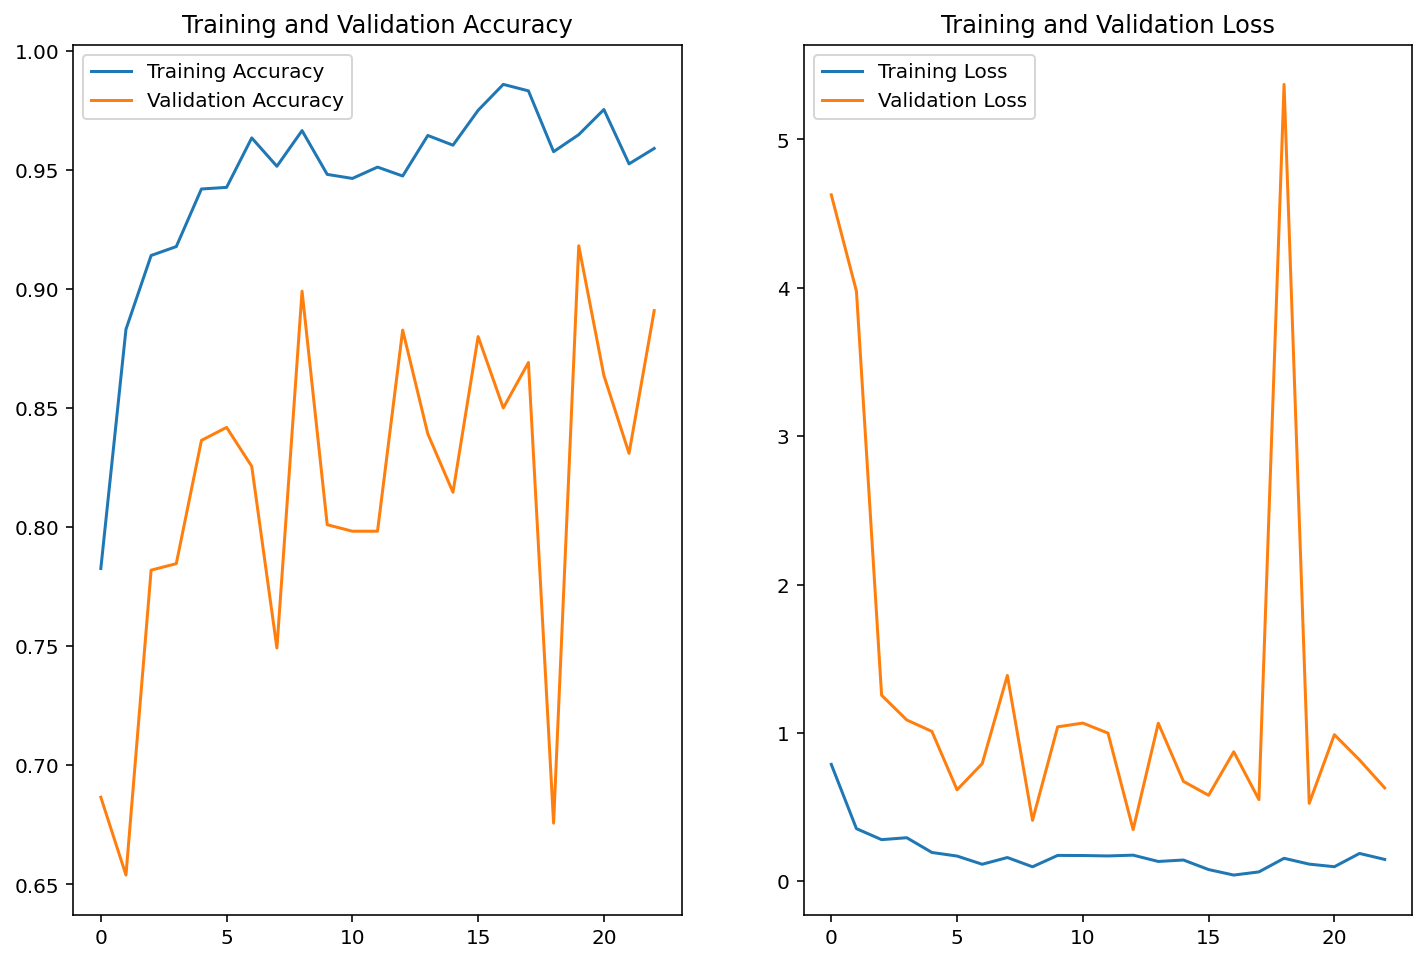

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(23)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

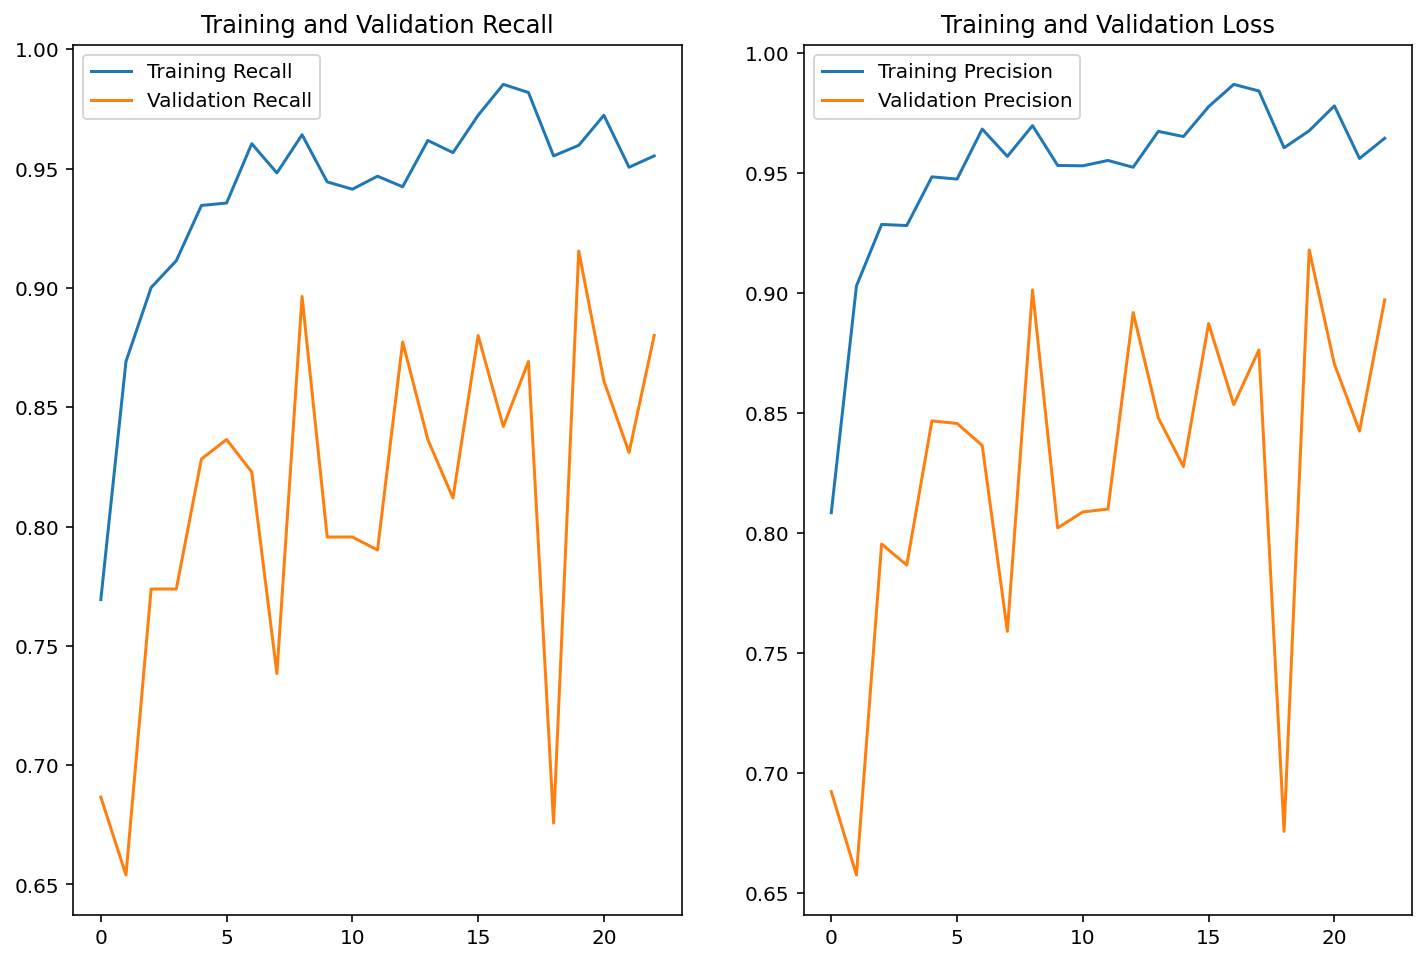

In [23]:
rec = history.history['recall']
val_rec = history.history['val_recall']

pre=history.history['precision']
val_pre=history.history['val_precision']

epochs_range = range(23)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, rec, label='Training Recall')
plt.plot(epochs_range, val_rec, label='Validation Recall')
plt.legend()
plt.title('Training and Validation Recall')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, pre, label='Training Precision')
plt.plot(epochs_range, val_pre, label='Validation Precision')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [24]:
model.evaluate(test_batches)

12/12 [==============================] - 1s 38ms/step - loss: 0.2965 - accuracy: 0.9128 - precision: 0.9304 - recall: 0.9101


[0.29646843671798706,
 0.912806510925293,
 0.9303621053695679,
 0.9100817441940308]

In [25]:
test_batches

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 5)), types: (tf.float32, tf.float32)>

In [26]:
np.argmax(next(iter(test_batches))[-1], axis=1)

array([4, 0, 0, 2, 0, 0, 2, 1, 3, 0, 0, 0, 3, 4, 0, 3, 2, 0, 2, 4, 2, 0,
       2, 0, 1, 3, 1, 4, 4, 3, 0, 4])

In [27]:
target = []
for image, label in test_batches:
    target.append(np.argmax(label,axis=1))

In [28]:
target

[array([4, 0, 0, 2, 0, 0, 2, 1, 3, 0, 0, 0, 3, 4, 0, 3, 2, 0, 2, 4, 2, 0,
        2, 0, 1, 3, 1, 4, 4, 3, 0, 4]),
 array([4, 4, 2, 1, 4, 0, 1, 3, 4, 3, 3, 4, 1, 1, 0, 0, 4, 2, 4, 0, 4, 1,
        1, 2, 4, 2, 1, 2, 4, 3, 3, 1]),
 array([0, 1, 3, 2, 3, 3, 2, 2, 4, 2, 0, 3, 1, 2, 4, 0, 4, 4, 1, 4, 0, 3,
        2, 2, 4, 1, 2, 0, 1, 1, 3, 3]),
 array([3, 3, 4, 4, 3, 2, 4, 4, 2, 0, 3, 4, 2, 1, 2, 4, 2, 1, 4, 0, 4, 0,
        1, 2, 2, 1, 4, 2, 2, 2, 3, 0]),
 array([3, 3, 0, 4, 4, 1, 3, 3, 2, 1, 2, 4, 3, 1, 3, 2, 1, 4, 3, 0, 3, 2,
        2, 4, 4, 0, 0, 3, 2, 3, 4, 4]),
 array([2, 4, 4, 1, 1, 3, 4, 2, 3, 1, 0, 4, 4, 4, 4, 2, 4, 1, 0, 3, 2, 4,
        3, 2, 4, 4, 1, 3, 3, 2, 1, 0]),
 array([0, 2, 2, 2, 4, 1, 0, 0, 1, 0, 2, 2, 0, 2, 3, 1, 0, 2, 2, 4, 3, 3,
        3, 4, 1, 0, 2, 3, 2, 3, 3, 4]),
 array([4, 2, 0, 0, 1, 2, 0, 2, 4, 3, 3, 1, 1, 3, 2, 1, 2, 3, 3, 1, 3, 1,
        4, 4, 0, 1, 2, 0, 4, 0, 3, 2]),
 array([0, 0, 3, 1, 1, 4, 0, 4, 3, 2, 1, 1, 0, 4, 0, 3, 0, 0, 1, 4, 2, 1,
        0, 2, 

In [29]:
target = tf.concat(target, axis=0)
target

<tf.Tensor: shape=(367,), dtype=int64, numpy=
array([4, 0, 0, 2, 0, 0, 2, 1, 3, 0, 0, 0, 3, 4, 0, 3, 2, 0, 2, 4, 2, 0,
       2, 0, 1, 3, 1, 4, 4, 3, 0, 4, 4, 4, 2, 1, 4, 0, 1, 3, 4, 3, 3, 4,
       1, 1, 0, 0, 4, 2, 4, 0, 4, 1, 1, 2, 4, 2, 1, 2, 4, 3, 3, 1, 0, 1,
       3, 2, 3, 3, 2, 2, 4, 2, 0, 3, 1, 2, 4, 0, 4, 4, 1, 4, 0, 3, 2, 2,
       4, 1, 2, 0, 1, 1, 3, 3, 3, 3, 4, 4, 3, 2, 4, 4, 2, 0, 3, 4, 2, 1,
       2, 4, 2, 1, 4, 0, 4, 0, 1, 2, 2, 1, 4, 2, 2, 2, 3, 0, 3, 3, 0, 4,
       4, 1, 3, 3, 2, 1, 2, 4, 3, 1, 3, 2, 1, 4, 3, 0, 3, 2, 2, 4, 4, 0,
       0, 3, 2, 3, 4, 4, 2, 4, 4, 1, 1, 3, 4, 2, 3, 1, 0, 4, 4, 4, 4, 2,
       4, 1, 0, 3, 2, 4, 3, 2, 4, 4, 1, 3, 3, 2, 1, 0, 0, 2, 2, 2, 4, 1,
       0, 0, 1, 0, 2, 2, 0, 2, 3, 1, 0, 2, 2, 4, 3, 3, 3, 4, 1, 0, 2, 3,
       2, 3, 3, 4, 4, 2, 0, 0, 1, 2, 0, 2, 4, 3, 3, 1, 1, 3, 2, 1, 2, 3,
       3, 1, 3, 1, 4, 4, 0, 1, 2, 0, 4, 0, 3, 2, 0, 0, 3, 1, 1, 4, 0, 4,
       3, 2, 1, 1, 0, 4, 0, 3, 0, 0, 1, 4, 2, 1, 0, 2, 4, 2, 2, 3, 0, 3,
     

              precision    recall  f1-score   support

   dandelion       0.93      0.99      0.96        70
       daisy       0.89      0.90      0.89        61
      tulips       0.88      0.87      0.88        85
  sunflowers       0.99      0.92      0.95        76
       roses       0.88      0.89      0.89        75

    accuracy                           0.91       367
   macro avg       0.91      0.91      0.91       367
weighted avg       0.91      0.91      0.91       367

--------------------------------------------------


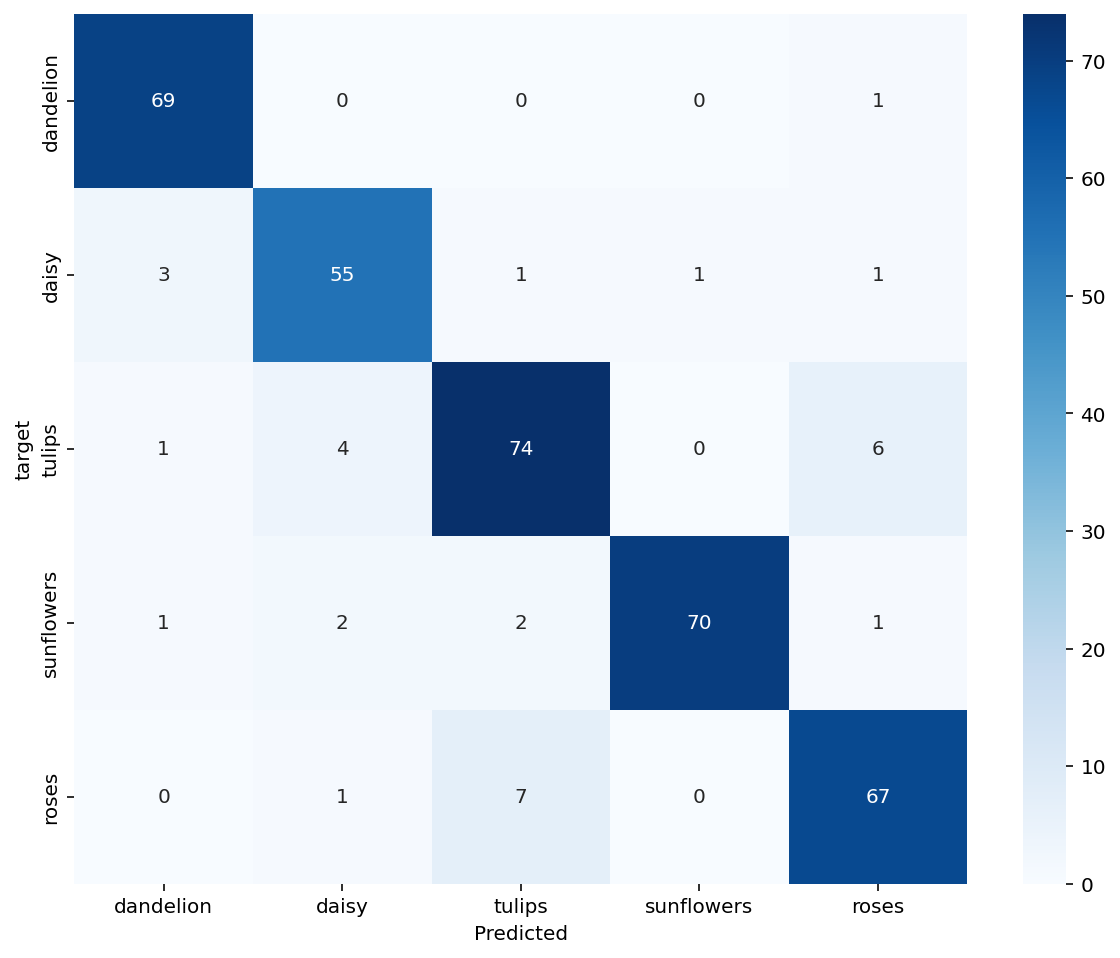

--------------------------------------------------


,dandelion,daisy,tulips,sunflowers,roses
dandelion,69,0,0,0,1
daisy,3,55,1,1,1
tulips,1,4,74,0,6
sunflowers,1,2,2,70,1
roses,0,1,7,0,67


In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd

pred = np.argmax(model.predict(test_batches), axis=1)
report = classification_report(target, pred, target_names=[get_label_name(i) for i in range(5)])
conf_mat = confusion_matrix(target, pred)
conf_mat_df = pd.DataFrame(conf_mat, index=[get_label_name(i) for i in range(5)], columns=[get_label_name(i) for i in range(5)])

print(report)
print("-"*50)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_df, annot=True, fmt=".0f", cmap='Blues', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('target')
plt.show()
print("-"*50)
display(conf_mat_df)

# 회고
## Keep
텐서플로우 내장 VGG19을 이용하여 transfer_learning을 진행하였다. 과적합을 방지하기 위해 배치정규화와 드롭아웃을 진행하였고 동시에 학습률을 조정하였다. 대신 에폭수를 늘려나가되, early_stop콜백함수를 통해 에폭수를 높이 되, validation loss가 떨어지는 방향으로 진행하였다.

## Problem
1. 초기엔 출력값 5개의 노드와 맞지 않다고 나왔었다.
2. 노드 aiffel에서 결국 터져서 다시 로컬로 와서 진행하였으나, 고해상도 이미지는 메모리부족 문제가 발생하였다.
3. 처음엔 이 전 개와 고양이 분류문제처럼 scale을 할 때 122.5를 나누고 1을 빼는 식으로 진행하였으나, 정확도가 오르지 않는 것 같았다.
---
- aiffel이 다시 되기 시작함
---
4. 작은 이미지 크기(160)와 VGG19 모델가지곤 올리기 힘들다고 판단하였다.(70-80%대의 정확도 유지)


## Try
1. 클래스를 원 핫인코딩으로 수정하고 원 핫인코딩엔 sparce_categorical_crossentropy는 사용하기 적절하지 않아 수정하였다.
2. 이미지 사이즈를 기존에 하려 했던 224가 아닌 160으로 줄여서 진행하였다.
3. MinMaxScale로 수정하였다.(255 나누기) 정확도가 이전보다는 증가하는 듯 했다.
---
- aiffel이 다시 되기 시작함
---
4. 이미지 크기(160->224)를 늘리고 모델(VGG19->MobileNet)으로 변경하였다.(accuracy: 0.9128)